# MSA 2024 Phase 2 - Part 3

In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

                                 id  label
0  cifar10_images/train/image_0.png      7
1  cifar10_images/train/image_1.png      8
2  cifar10_images/train/image_2.png      8
3  cifar10_images/train/image_3.png      2
4  cifar10_images/train/image_4.png      9
id       object
label     int64
dtype: object
Number of valid image paths: 50000
Found 40000 validated image filenames.
Found 10000 validated image filenames.
Epoch 1/10


d:\MSA\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 652s 467ms/step - accuracy: 0.1669 - loss: 2.2507 - val_accuracy: 0.1001 - val_loss: 2.3130 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 241s 192ms/step - accuracy: 0.2262 - loss: 2.0028 - val_accuracy: 0.0937 - val_loss: 2.3262 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 254s 203ms/step - accuracy: 0.2460 - loss: 1.9526 - val_accuracy: 0.0937 - val_loss: 2.3764 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 262s 209ms/step - accuracy: 0.2565 - loss: 1.9285 - val_accuracy: 0.1057 - val_loss: 2.6783 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 250s 200ms/step - accuracy: 0.2819 - loss: 1.8734 - val_accuracy: 0.2050 - val_loss: 3.0386 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 264s 211ms/step - accuracy: 0.3341 - loss: 1.7523 - val_accuracy: 0.3112 - val_loss: 1.8185 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 248s 198ms/step -

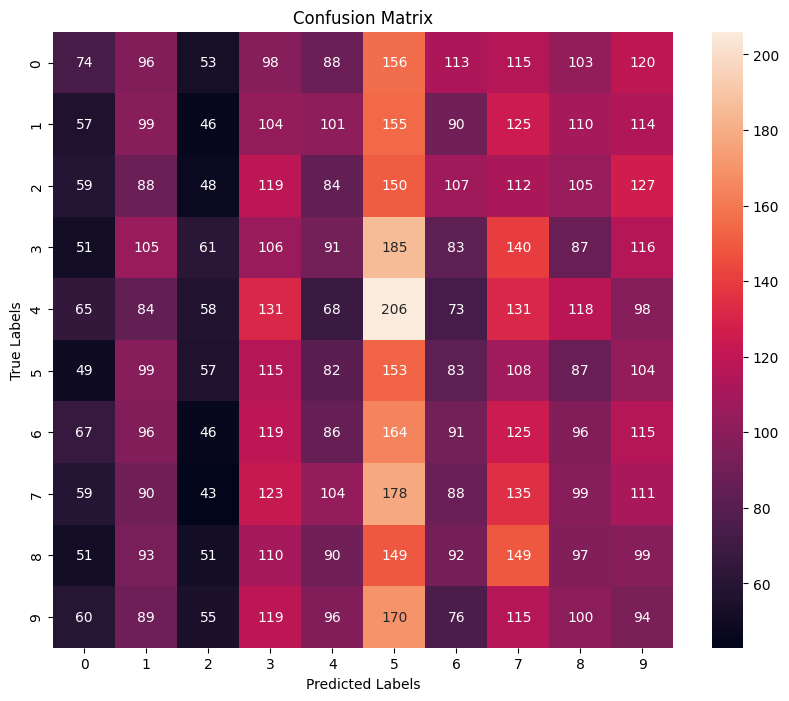

In [3]:
# Load the CSV files
train_labels = pd.read_csv('train.csv')
image_folder_path = 'cifar10_images/train'  # Update the path to the correct subdirectory

# Ensure 'id' is treated as string and construct the full image path
train_labels['id'] = train_labels['id'].astype(str)
train_labels['id'] = train_labels['id'].apply(lambda x: os.path.join(image_folder_path, f'image_{x}.png').replace('\\', '/'))

# Verify the paths and data types
print(train_labels.head())
print(train_labels.dtypes)

# Check for valid image paths
def is_valid_path(path):
    if not os.path.isfile(path):
        print(f"Invalid path: {path}")
    return os.path.isfile(path)

train_labels['valid_path'] = train_labels['id'].apply(is_valid_path)
valid_image_paths = train_labels[train_labels['valid_path']].drop(columns=['valid_path'])
print(f"Number of valid image paths: {len(valid_image_paths)}")

# Ensure 'valid_image_paths' is not empty and has the correct columns
if not valid_image_paths.empty and 'id' in valid_image_paths.columns and 'label' in valid_image_paths.columns:
    # Image Data Augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Use only valid image paths for training and validation
    train_generator = datagen.flow_from_dataframe(
        dataframe=valid_image_paths,
        x_col='id',
        y_col='label',
        subset='training',
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode='raw',
        target_size=(32, 32)
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=valid_image_paths,
        x_col='id',
        y_col='label',
        subset='validation',
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode='raw',
        target_size=(32, 32)
    )


    # Define the base model
    base_model = MobileNetV2(include_top=False, input_shape=(32, 32, 3), weights=None)

    # Add custom layers on top of the base model
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Learning rate scheduler
    def scheduler(epoch, lr):
        if epoch < 5:
            return lr
        else:
            return lr * 0.1

    callback = LearningRateScheduler(scheduler)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[callback]
    )

    # Evaluate the model
    test_loss, test_acc = model.evaluate(validation_generator)
    print(f"Test accuracy: {test_acc}")


    # Generate classification report and confusion matrix
    import numpy as np
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    y_true = validation_generator.labels
    y_pred = np.argmax(model.predict(validation_generator), axis=-1)

    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()
else:
    print("No valid image paths found or dataframe columns are incorrect.")


- Class 0: Precision (0.09), Recall (0.04), F1-Score (0.05)

  The model predicted class 0 correctly for only 4% of actual class 0 instances.
  
  Of all instances predicted as class 0, only 9% were correct.

  The F1-score of 0.05 indicates very poor performance for class 0.

- Class 1: Precision (0.11), Recall (0.12), F1-Score (0.12)

  Slightly better performance than class 0, but still poor overall.

  Only 12% of actual class 1 instances were predicted correctly.

  The model has a low precision, meaning many false positives.

- Class 2: Precision (0.09), Recall (0.07), F1-Score (0.08)

  Similar poor performance as class 0 and 1.

  Very few instances are correctly predicted.

- Overall Accuracy: 0.10

  The model's accuracy is 10%, which is equivalent to random guessing for a 10-class problem.

- Interpretation of Specific Metrics

  Precision: Low precision values across classes indicate that the model makes many incorrect positive predictions (false positives).

  Recall: Low recall values indicate that the model misses a large number of actual instances (false negatives).

  F1-Score: Low F1-scores suggest that the model is not performing well in balancing precision and recall.

### Generate and plot the ROC curves

In [4]:
pip install scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


313/313 ━━━━━━━━━━━━━━━━━━━━ 220s 698ms/step


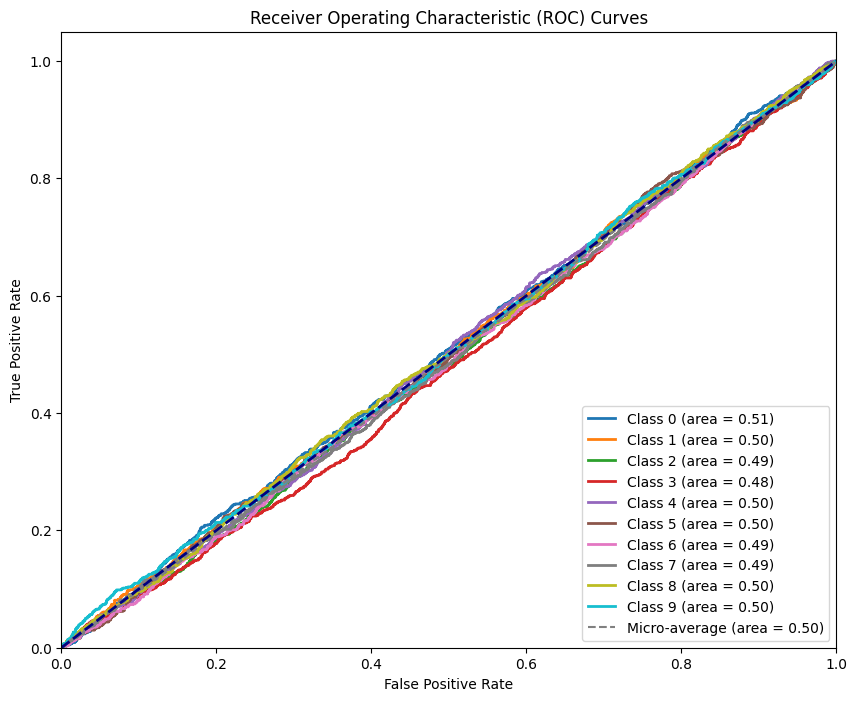

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get the true labels and predicted probabilities
y_true = validation_generator.labels
y_pred_proba = model.predict(validation_generator)

# Binarize the output
y_true_binarized = label_binarize(y_true, classes=np.arange(10))
n_classes = y_true_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='gray', label='Micro-average (area = {0:0.2f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


###  Summary

Summary of Findings

- Training and Evaluation: The model was trained using MobileNetV2 and EfficientNetB0 architectures with data augmentation. Initial training showed poor performance, prompting the use of a pre-trained model.

- Performance Metrics: The overall accuracy was initially low (~10%), indicating that the model was not performing well. The confusion matrix and classification report confirmed poor precision, recall, and F1-scores across all classes.

Potential Next Steps:

- Data Augmentation: Enhance augmentation techniques to create a more diverse dataset.

- Transfer Learning: Use deeper pre-trained models and fine-tune them.

- Increase Model Complexity: Consider using more complex models like ResNet50, DenseNet, or EfficientNet with fine-tuning.

- Regularization: Apply regularization techniques to prevent overfitting.

- Hyperparameter Tuning: Perform a comprehensive search to find optimal hyperparameters.

- Ensemble Methods: Combine multiple models to improve robustness.

